In [22]:
from data_manager import get_data, split_data
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pandas as pd
from sklearn.preprocessing import StandardScaler

ds = get_data()
y = np.array(ds['target'])
X = np.array(ds.drop(['target'], axis=1)) # the data

X_sub, X_test, y_sub, y_test = split_data(X, y, 5)
X_train, X_val, y_train, y_val = split_data(X_sub, y_sub, 3)
def make_one_hot(*y):
    res = []
    for y_i in y:
        y_1hot = to_categorical(y_i)
        res.append(y_1hot)
    return res

def scale_data(*X):
    res = []
    scaler = StandardScaler()
    for X_i in X:
        scaled_X = scaler.fit_transform(X_i)
        res.append(scaled_X)
    return res

def plot_epochs_vs_loss(hist):
    training_results = hist.history
    num_epochs = len(training_results['loss'])
    epochs_pl = np.linspace(1, num_epochs, num_epochs, dtype=int)

    plt.plot(epochs_pl, training_results['loss'], label='Training')
    plt.plot(epochs_pl, training_results['val_loss'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

# y_train, y_val, y_test = make_one_hot(y_train, y_val, y_test) 

20


(array([ 96, 148, 185, 275, 383, 387, 414, 586, 600, 831, 834]),)

## Lets just try to do a simple MLP to begin
### 3 Layers, 10 20 5

In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import tensorflow

batch_size=32
epochs=40
learning_rate=0.001
num_classes = len(np.unique(y_train))
in_shape = X_train.shape[1:]
metrics = [
      tensorflow.keras.metrics.TruePositives(name='tp'),
      tensorflow.keras.metrics.FalsePositives(name='fp'),
      tensorflow.keras.metrics.TrueNegatives(name='tn'),
      tensorflow.keras.metrics.FalseNegatives(name='fn'), 
      tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),
      tensorflow.keras.metrics.AUC(name='auc'),
]


# loss_func = keras.losses.CategoricalCrossentropy()
loss_func = keras.losses.BinaryCrossentropy()

model = Sequential()
model.add(Dense(30, activation='sigmoid', input_shape=in_shape, dtype=float))
model.add(Dropout(0.2))
model.add(Dense(40, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(20, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

opt = Adam(learning_rate=learning_rate)
model.compile(loss=loss_func,
             optimizer=opt,
             metrics=metrics)
hist = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(X_val, y_val))
score = model.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score[0])
print('ROC AUC:', score[1])


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 915 samples, validate on 229 samples
Epoch 1/40
915/915 [==============================] - 1s 620us/sample - loss: 0.5036 - tp: 3.0000 - fp: 146.0000 - tn: 758.0000 - fn: 8.0000 - accuracy: 0.8317 - precision: 0.0201 - recall: 0.2727 - auc: 0.4558 - val_loss: 0.3004 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 225.0000 - val_fn: 4.0000 - val_accuracy: 0.9825 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1278
Epoch 2/40
915/915 [==============================] - 0s 98us/sample - loss: 0.2363 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 904.0000 - fn: 11.0000 - accuracy: 0.9880 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.3605 - val_loss: 0.1647 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 225.0000 - val_fn: 4.0000 - val_accuracy: 0.

In [5]:
print(score)

[0.08376548903952077, 0.0, 0.0, 282.0, 5.0, 0.9825784, 0.0, 0.0, 0.8812056]


In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow import print as tprint
results = hist.history
epochs_pl = np.linspace(1,epochs,epochs, dtype=int)
plt.plot(epochs_pl, results['loss'])
plt.plot(epochs_pl, results['val_loss'])
predictions = model.predict(X_test)
# conf = confusion_matrix(y_test[:,1], predictions[:,1])
# predictions

# well, this doesnt work like I thought it would...
# whoops, we need more data



In [25]:
import numpy as np 

from data_manager import get_data
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

ds = get_data()
y = np.array(ds['target'])
X = np.array(ds.drop(['target'], axis=1)) # the data

X_sub, X_test, y_sub, y_test = split_data(X, y, 5)
X_train, X_val, y_train, y_val = split_data(X_sub, y_sub, 3)
X_train, X_val, X_test = scale_data(X_train, X_val, X_test)

In [70]:
import tensorflow as tf
from tensorflow import keras

neg, pos = np.bincount(ds['target'])

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        model = keras.Sequential([
            Dense(30, activation='sigmoid',
              input_shape=(train_features.shape[-1],)),
            Dropout(0.5),
            Dense(40, activation='sigmoid'),
            Dropout(0.5),
            Dense(20, activation='sigmoid'),
            Dropout(0.5),
            Dense(1, activation='sigmoid',
                             bias_initializer=output_bias),
        ])

    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.001),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

epochs = 100
batch_size = 512

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

initial_bias = np.log(pos/neg)
model = make_model(output_bias = initial_bias)

# results = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
# print("Loss: {:0.4f}".format(results[0]))

[0.06852874131581198, 0.0, 0.0, 282.0, 5.0, 0.0, 0.0, 0.9758865]


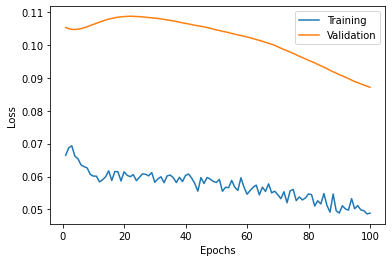

In [69]:
hist = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(X_val, y_val), verbose=0)
plot_epochs_vs_loss(hist)
score = model.evaluate(X_test, y_test, verbose=0)
print(score)

### Class weights
In SVM, we used 'balanced' class weights to give the positive class more power.

[0.14939093870152995, 5.0, 16.0, 266.0, 0.0, 0.23809524, 1.0, 0.9861702]


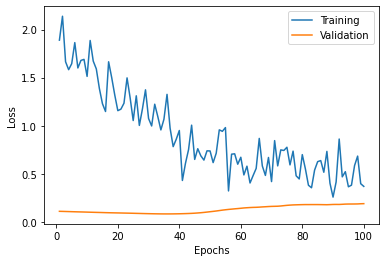

In [134]:
total = neg+pos
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

model = make_model(output_bias = initial_bias)

hist = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(X_val, y_val), 
                class_weight=class_weight,
                verbose=0)
plot_epochs_vs_loss(hist)
score = model.evaluate(X_test, y_test, verbose=0)
print(score)

### Try oversampling the minority class


In [128]:
pos_idxs, neg_idxs = np.where(y_train == 1)[0], np.where(y_train == 0)[0]
ids = np.arange(len(pos_idxs))
choices = np.random.choice(ids, len(neg_idxs))
over_sampled_pos_idxs = pos_idxs[choices]
X_neg, y_neg = X_train[neg_idxs], y_train[neg_idxs]
X_pos_over_sampled, y_pos_over_sampled = X_train[over_sampled_pos_idxs], y_train[over_sampled_pos_idxs]

## now concatonate the original data with this data!
X_train_oversampled = np.r_[X_neg,X_pos_over_sampled]
y_train_oversampled = np.r_[y_neg, y_pos_over_sampled]

print(f'Oversampled data shapes \nFeatures: {X_train_oversampled.shape}\nLabels: {y_train_oversampled.shape}')
order = np.arange(len(X_train_oversampled))
np.random.shuffle(order)
X_train_oversampled, y_train_oversampled = X_train_oversampled[order], y_train_oversampled[order]

Oversampled data shapes 
Features: (1810, 10)
Labels: (1810,)


array([0., 0., 0., ..., 0., 0., 1.])

Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping
[0.14424483088666137, 5.0, 15.0, 267.0, 0.0, 0.25, 1.0, 0.99361694]


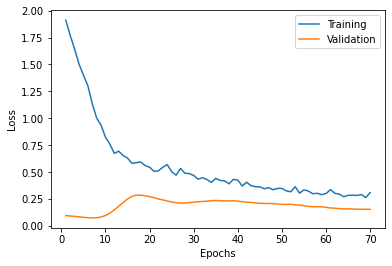

In [139]:
epochs = 200
def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        model = keras.Sequential([
            Dense(30, activation='relu',
              input_shape=(train_features.shape[-1],)),
            Dropout(0.5),
            Dense(40, activation='relu'),
            Dropout(0.5),
            Dense(20, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid',
                             bias_initializer=output_bias),
        ])

    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.001),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

model = make_model(output_bias = initial_bias)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='tp', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

hist = model.fit(X_train_oversampled, y_train_oversampled,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(X_val, y_val),
                callbacks=[early_stopping],
                verbose=0)

plot_epochs_vs_loss(hist)
score = model.evaluate(X_test, y_test, verbose=0)
print(score)